# Learning the Helmholtz-Hodge Decomposition

In the following notebook we'll following the aforementioned paper by Tompson et al. {cite}`tompson2017` and train a neural network that can essentially perform a Helmholtz-Hodge decomposition. This is a very classic and time consuming part of many numerical solvers, and enables splitting an arbitrary vector field into a solenoidal (divergence-free) and irrotational part (the pressure gradient). Because this is traditionally very time consuming, it's an interesting goal for a learned approach. As a stepping stone towards integrating full solvers, we'll formulate a physics-based loss via a discretized PDE-constraint.


## Solving Navier-Stokes

To motivate the topic, let's briefly revisit how the incompressible Navier-Stokes equations are often solved: a fundamental variant employs operator splitting to separately solve advection and pressure correction (giving first-order accuracy in time). Thus, given an arbitrary flow field $\mathbf{u}$, we compute a self advection step solving $\frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \cdot \nabla \mathbf{u} = 0$. This step is usually efficient, with a complexity linear in the number of discretization points, and gives an advected flow field $\tilde{\mathbf{u}}$. 

The pressure-projection (or _Chorin_ projection) step using the aforementioned Helmholtz-Hodge decomposition requires solving a Poisson problem $\nabla ^ 2 p = \nabla \cdot \tilde{\mathbf{u}}$, an elliptic PDE that is non-trivial to solve in the general case. In the Navier-Stokes setting it gives an instantaneous scalar pressure field $p$, the gradient of which happens to capture the divergent parts of the velocity field. Hence, once we subtract $\nabla p$ we obtain a divergence free field that satisfies $\nabla \cdot \mathbf{u} = 0$.

Our goal below will be to obtain $p$ for new velocity inputs $\mathbf{u}$, and the neat property of this problem is
that we can perform this training without a supervised setup. I.e., we don't have to precompute a large number of $(\mathbf{u},p)$ pairs to train this, but rather we'll rely on the discretized PDE-constraint. This could be called an _unsupervised_ training, but this labeling is misleading, as the training target in all "unsupervised" cases is simply computed on the fly.

The more important conceptual aspect of the approach is that we have a target PDE $\nabla \cdot \mathbf{u} = 0$, that we can discretize on our computational domain with a suitable finite-difference operator. Once we do this in a differentiable way, we can directly use the FD operator to train our neural network: as we aim for minimizing $\nabla \cdot \tilde{\tilde{\mathbf{u}}}$, this effectively gives us an $L_2$ loss with a target of 0. From this loss, we can back-propagate through the discretized divergence operator to obtain a gradient for $\mathbf{u}$, which is computed (as outlined above), as $\tilde{\tilde{\mathbf{u}}} = \tilde{\mathbf{u}} - \nabla p$, where $p$ is the output of our neural network $f$ with parameters $\theta$. 
As we know that the divergence is all that is required to uniquely determine the pressure field, we can pass the divergence to $f$ to simplify the inference task.
Thus $f( \nabla \cdot \tilde{\mathbf{u}} ; \theta)$ will receive a gradient backpropagated from the loss through all steps to update its state $\theta$ such that the velocity field above will end up divergence free.

Putting these steps together, we aim for solving the minimization problem
$$
\text{arg min}_{\theta} \sum_i \Big( \nabla \cdot (\tilde{\mathbf{u}} - \nabla f(\nabla \cdot \tilde{\mathbf{u}} ; \theta)) \Big)^2 ,
$$
where the $i$ subscript denotes an arbitrary number of different inputs, e.g., from a minibatch at training time.


## Setting up the Discrete PDE

As before, we'll use the `PhiFlow` framework. 
The cell below installs it via `pip`, and imports the PyTorch backend together with `tqdm` for tracking the progress. Note that this notebook can be switched to TensorFlow quite easily by changing the import below.

In [1]:
!pip install --quiet phiflow==3.1 tqdm
from tqdm import tqdm
from phiml import nn

from phi.torch.flow import *
# this notebook largely works identically with tensorflow - try replacing the line above with this one
#from phi.tf.flow import *  

Let's define some basic constants, the grid resolution (which we'll reuse as _physical_ dimensions in PhiFlow), the number of different flow fields we'll consider for training, and the batch size.

In [2]:
RES_X = 32
RES_Y = 32

NUM_SAMPLES_TRAIN = 100
BATCH_SIZE = 10

We will use random, periodic flow fields generated via PhiFlow's frequency-based synthesis. The next cell will pre-compute all these flow fields (100 in total), and visualize an example. Note, we're simply taking random, divergent flow fields here. We don't know what the correct divergence-free counterparts are.

Initial L2 of divergence: 195.28241, max=1.8969224691390991


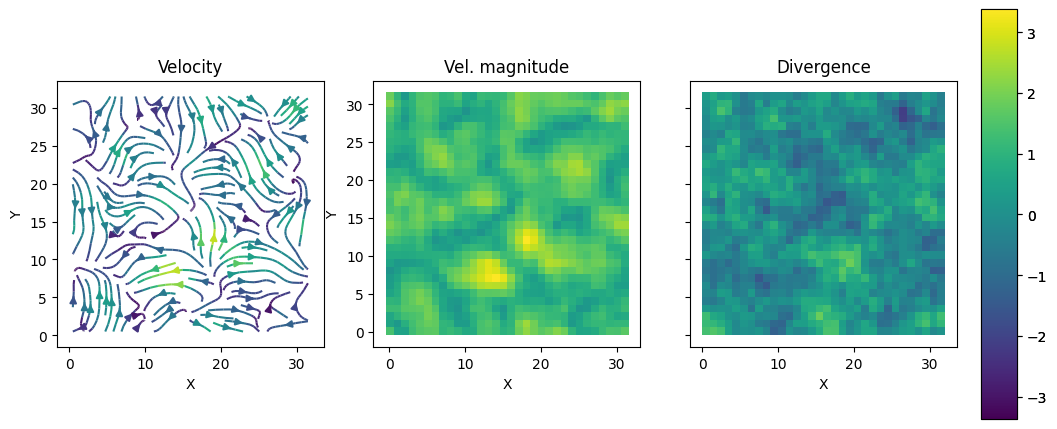

In [3]:
vel = field.StaggeredGrid(
    values=field.Noise(batch(batch=NUM_SAMPLES_TRAIN)),
    extrapolation=math.extrapolation.PERIODIC,
    bounds=geom.Box(x=RES_X, y=RES_Y), 
    resolution=math.spatial(x=RES_X, y=RES_Y),
)

# plot the velocity field
plot = vis.plot({ "velocity": vel.batch[0], "vel. magnitude": math.vec_length(vel.batch[0].at_centers().values), "divergence": field.divergence(vel.batch[0]), })

# for initial assessments, let's print the typical divergence of an input
print( f"Initial L2 of divergence: {math.l2_loss(field.divergence(vel.batch[0]))}, max={field.divergence(vel.batch[0]).values.max}" )

Here you can see the flowlines together with velocity magnitudes and the divergence per cell. The latter is exactly what we're aiming for removing. This visualization shows that the divergence is smaller than the actual magnitude of the velocities, with an average of around 0.4, as indicated by the L2 output right above the images.

Next, we will define a Navier-Stokes simulation step. Given our reduced setup without external forces or obstacles, it's very simple: a call to an advection function in PhiFlow, followed by `fluid.make_incompressible()` to invoke the Poisson solver. We'll directly annotate this function and the following ones for JIT compilation with `@jit_compile`. This is important for good performance on GPUs, but it makes debugging much harder. So when changing the code, it's highly recommended to remove them. The code will work just as well without, just slower. Once everything's running as it should, re-activate JIT compilation for the _real_ training runs. 


In [4]:
@jit_compile
def step(v, dt = 1.0):
    v = advect.mac_cormack(v, v, dt)
    v, p = fluid.make_incompressible(v, [])
    return v, p

v,p = step(vel)

/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/math/_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")
/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:800: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)
/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/math/_optimize.py:631: UserWar

This cell directly runs the solver on our random velocity field from before. If you're curious, you can plot it via `vis.plot()`. However, as we've demonstrated in earlier chapters that PhiFlow's NS solver works, we'll focus on the NN training. Our goal below is to train the network without having to precompute many pressure examples with a function like `make_incompressible()` above. Instead, we'll use the differentiable divergence operator to set up our training.


## Neural Network Training

As NN architecture for an elliptic problem, an architecture with global communication is suitable. Below, we initialize a U-Net, but feel free to try the ResNet variant, which works less well due to its lack of a wide receptive field. (Given that property, it's doing surprisingly well.) As we're dealing with a periodic domain for simplicity, the NN likewise needs to be configured for periodic processing via `periodic=True`. It's input is a single channel (the divergence), and the output a very different content, the pressure. However, for the network this is likewise simply a single, scalar channel. The `filters=24` determine the total number of parameters. Feel free to increase this to improve accuracy (and reduce computational performance of the NN inference). This is the classic accuracy vs performance trade-off that NNs share with all classic numerical methods.


In [5]:
from phiml import nn 

network = nn.u_net(in_channels=1, out_channels=1, levels=4, periodic=True, batch_norm=False, in_spatial=(RES_X, RES_Y), filters=24)

# uncomment this for an alternative architecture that could generalize to different resolutions
#network = nn.res_net(in_channels=1,out_channels=1,layers=[32,32,32])

# print network and parameter summary
from phiml.backend import BACKENDS
if any([b.name == 'torch' for b in BACKENDS]):
    print(network)
    print("Total number of trainable parameters: "+ str( sum(p.numel() for p in network.parameters()) ))
elif any([b.name == 'tf' for b in BACKENDS]):
    network.summary() 


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (1): Identity()
      (2): ReLU()
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (4): Identity()
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): ResNetBlock(
      (sample_input): Identity()
      (bn_sample): Identity()
      (bn1): Identity()
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
      (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up1): Up(
    (up): Upsample(scale_factor=2.0, mode='bilinear')
    (conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)


As can be seen here, the NN has around 83k trainable parameters.

Next we can setup the training process: the `eval_nn()` function below takes a batch of flow fields, computes their divergence, and calls the NN with these inputs. The resulting scalar field is converted to a PhiFlow tensor and interpreted as a pressure field. Its gradient is subtracted from the input flow following Helmholtz-Hodge. Our goal is to make the resulting flow field `v` incompressible, i.e., it's divergence should be minimal.

To achieve this goal, we'll define a loss function that computes the $L^2$ of the per-cell divergence `loss_div()`. For convenience, we'll also define a helper functions `loss_func` that will be used by PhiFlow. This function evaluates the NN for an input, and computes the resulting loss. PhiFlow will call this function and then make sure the gradient backpropagates from the single loss value through the discrete divergence operator to the weights of the NN. Note that in the incompressible setting we always remove the divergence present in the flow, and hence the time step does not play a role.


In [6]:
@jit_compile
def eval_nn(v):
    nn_input = field.divergence(field=v, order=2)
    p = math.native_call(network, nn_input.values)
    p = field.CenteredGrid(
        values=p,
        extrapolation=math.extrapolation.PERIODIC, 
        bounds=geom.Box(x=RES_X, y=RES_Y),
        resolution=spatial(x=RES_X, y=RES_Y),
    )
    grad_pres = field.spatial_gradient(p, boundary=math.extrapolation.PERIODIC, at=v.sampled_at) 
    v = v - grad_pres
    return v, p

# loss functions

@jit_compile
def loss_div(v):
    div = field.divergence(field=v,order=2)
    div_sum = 2 * math.l2_loss(div)
    return div_sum, div

@jit_compile
def loss_func(v):
    v, p = eval_nn(v)
    loss, div = loss_div(v)  
    return math.mean(loss,dim=batch), v, p

Before training the network, let's look at what a randomly initialized network produces. Below we evaluate the untrained network on the first flow field input:

Loss for untrained network: 390.21857


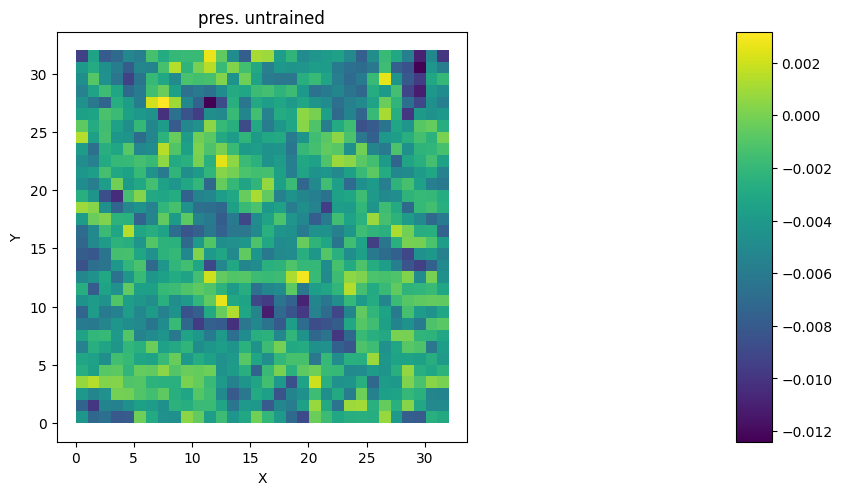

In [7]:
vel_untrained, pres_untrained = eval_nn(vel.batch[0])

# optionally, visualize the outputs: this doesn't look much different from before as the NN is untrained
#plot = vis.plot( {"vel untrained": vel_untrained.batch[0], "vel len. untrained": math.vec_length(vel_untrained.batch[0].at_centers().values), "div. untrained": field.divergence(vel_untrained.batch[0]), })

# print the loss and divergence sum of the corrected velocity from untrained NN
loss, div_untrained = loss_div(vel_untrained)
print(f"Loss for untrained network: {loss}")

# also, we visualize the pressure field
plot = vis.plot(pres_untrained.batch[0],title="pres. untrained")

Not surprisingly, the pressure field looks quite random, and the loss in terms of divergence is large.

## Training

With our setup so far, training is very simple: we simply choose a few of the random flow fields, and evaluate the network, and change its weights so that the divergence loss becomes smaller. We simply loop over our precomputed flow fields without randomization below for a fixed number of epochs. Our network converges surprisingly fast. After a few epochs the loss should have decreased by more than two orders of magnitude.

In [8]:
optimizer = nn.adam(network, learning_rate=5e-3)
for epoch in tqdm(range(15)):
    for b in range(int(NUM_SAMPLES_TRAIN / BATCH_SIZE)):
        vel_input = vel.batch[b*BATCH_SIZE:b*BATCH_SIZE + BATCH_SIZE]
        loss, pred_v, pred_p = nn.update_weights(
            network, optimizer, loss_func, vel_input
        )

loss, _,_ = loss_func(vel)
print(f"Final loss={loss.numpy()}")  

  0%|          | 0/15 [00:00<?, ?it/s]/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1091: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(eval_nn) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__name__} will be ignored.", RuntimeWarning)
/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1091: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(loss_div) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__name__} will be ignored.", RuntimeWarning)
/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1091: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(eval_nn) will be ignored.
  warnings.warn(f"PyTorch does not support nested tr

Final loss=0.6785882711410522


It's good to see the loss going down, but of course the big question now is: how does this network fare with new inputs. I.e., how well does it generalize to different, arbitrary flows given that it was only trained on the synthetic, randomly sampled flows.

## Testing with New Inputs

We can check this by producing a few new inputs. Below, we'll likewise use PhiFlow's noise generation to get new fields, but to make things interesting we're increasing the scale by a factor of $2 \times$. Hence, the network will receive divergence inputs with magnitudes it hasn't seen before. These samples are effectively _out of the distribution_ of the training inputs.

In [9]:
NUM_SAMPLES_TEST = 10

vel_test = field.StaggeredGrid(
    values=field.Noise(math.batch(batch=NUM_SAMPLES_TEST),scale=2.), 
    extrapolation=math.extrapolation.PERIODIC,
    bounds=geom.Box(x=RES_X, y=RES_Y),
    resolution=math.spatial(x=RES_X, y=RES_Y),
)


Now we run our trained network and the solver (for comparison) on these inputs:

/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/math/_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


Original, mean divergence=2059.143, div. max=4.946
NN, mean divergence=11.510, div. max=0.417
Solver, mean divergence=0.000, div. max=0.000


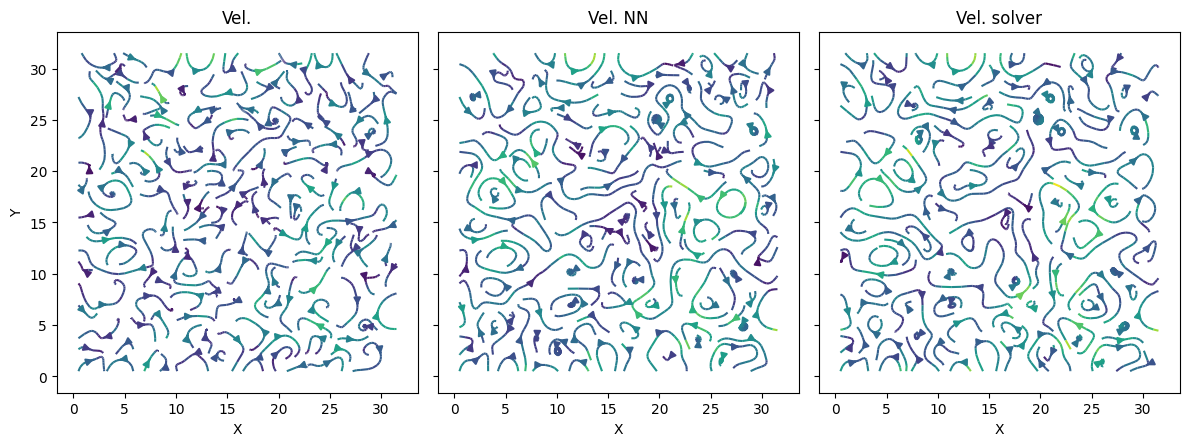

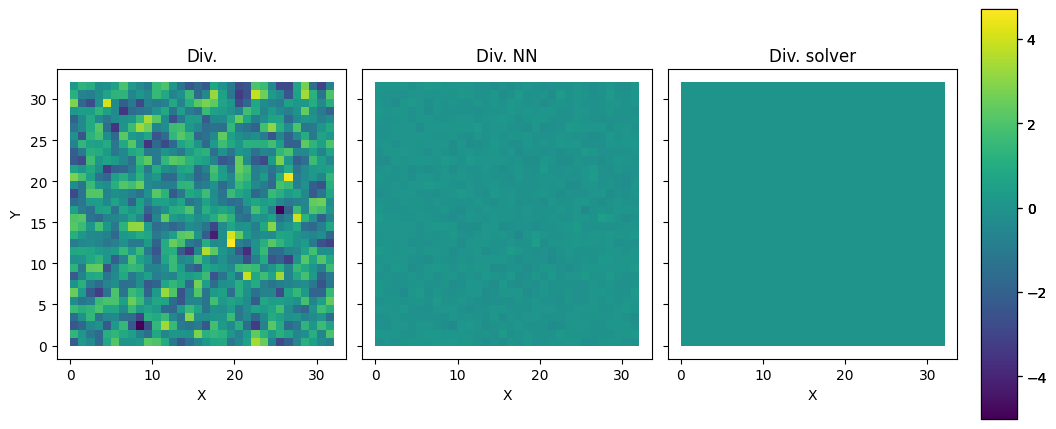

In [10]:
vel_nn, p_nn          = eval_nn(vel_test)
vel_solver, p_solver  = fluid.make_incompressible(vel_test, [])

loss, div = loss_div(vel_test)
print(f"Original, mean divergence={loss.mean:.3f}, div. max={math.max(div.values).mean:.3f}")

loss, div = loss_div(vel_nn)
print(f"NN, mean divergence={loss.mean:.3f}, div. max={math.max(div.values).mean:.3f}")

loss, div = loss_div(vel_solver)
print(f"Solver, mean divergence={loss.mean:.3f}, div. max={math.max(div.values).mean:.3f}")

plot = vis.plot({ "vel.": vel_test.batch[0],  "vel. NN": vel_nn.batch[0],  "vel. solver": vel_solver.batch[0] })
plot = vis.plot({ "div.": field.divergence(vel_test.batch[0]), "div. NN": field.divergence(vel_nn.batch[0]), "div. solver": field.divergence(vel_solver.batch[0]), })

The quantitative evaluation confirms that our network has learned to reduce the divergence. The remaining one is larger than the one from PhiFlow's solver, but nonetheless orders of magnitude smaller than the original one. The images at the bottom nicely visualize this.

Next, let's check what pressure field the network has actually learned to produce.

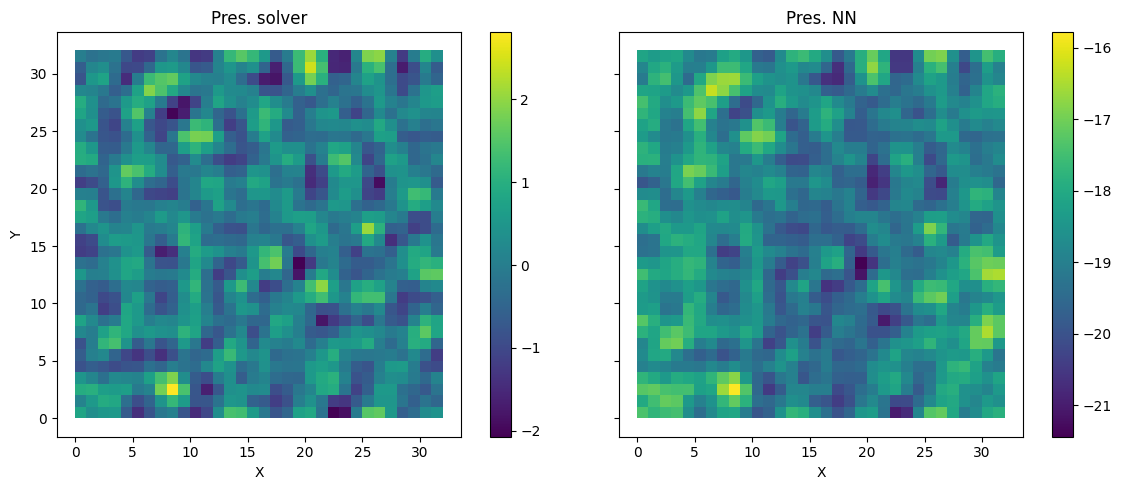

In [12]:
# plot the pressure on the training data, compared with the pressure given by traditional solver.
plot = vis.plot({"pres. solver": p_solver.batch[0], "pres. NN": p_nn.batch[0]}, same_scale=False)

Interestingly, these fields share some similarities in terms of their structures, but are clearly not identical. Also, they typically have strongly varying magnitudes (the NN training is stochastic, so the differences can vary). Often, the NN learns to generate values that are 10 times larger, while PhiFlows pressure solvers is constrained to produce values with a zero mean.

Nonetheless, as measured above, the pressure field of the network successfully removes most of the divergence, and mathematically, the Poisson problem here has a null-space in the form of a constant offset: the offset does not play a role once we take the derivatives, and hence all offsets are perfectly valid solutions. Our differentiable loss used for training does not have any constraint on absolute values, and hence the network is free to use any offset it happens to produce from its random initialization.

## Tougher Tests: Fluid Simulations with Obstacles

Our initial goal were Navier-Stokes solvers, and hence it's import to check whether our network can actually cope with inputs in the form of flow fields produced by a fluid solver. After all, it was only trained on the synthetic, randomized fields that are quite different from the motions of fluids. To make things more interesting, we'll directly include a buoyant smoke plume to drive the simulation, and an obstacle. 

The next cell sets up a simple domain with a smoke source and a square obstacle right above it.

In [13]:
smoke = CenteredGrid(0, extrapolation.PERIODIC, x=RES_X, y=RES_Y, bounds=Box(x=RES_X, y=RES_Y)) 
vel_smk = StaggeredGrid(0, extrapolation.PERIODIC, x=RES_X, y=RES_Y, bounds=Box(x=RES_X, y=RES_Y)) 

RECTANGLE = Obstacle(Box(x=(12, 20), y=(18, 20)))
INFLOW_LOCATION = tensor((16, 5), channel(vector='x,y'))
INFLOW = 0.6 * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.PERIODIC, x=RES_X, y=RES_Y, bounds=Box(x=RES_X, y=RES_Y))
CYLINDER = Obstacle(geom.infinite_cylinder(x=16, y=20, radius=3, inf_dim=None))

In our NN-supported solver, we now have some options regarding how to impose the zero-velocity boundary conditions for the obstacle. The safest way to handle them is to set velocities both before and after invoking the NN-based pressure correction step. The former ensure the network sees the solid obstacle, and the second one ensures the boundaries are fulfilled even if the network has made slight errors at the obstacle boundary. Hence, we'll call PhiFlow's `apply_boundary_conditions()` two times in the `step_nn()` function below.

In parallel, we'll also define a `step_obs()` function that runs a classic flow solver without NN for comparison.

In [14]:
dt = 0.1

@jit_compile
def step_nn(v, dt, f, obstacle):
    v = v + f * dt
    v = advect.mac_cormack(v, v, dt)
    v = fluid.apply_boundary_conditions(v, obstacle)
    nn_input = field.divergence(field=v, order=2)
    p = math.native_call(network, nn_input.values)

    p = field.CenteredGrid( values=p,
        extrapolation=math.extrapolation.PERIODIC,
        bounds=geom.Box(x=RES_X, y=RES_Y),
        resolution=spatial(x=RES_X, y=RES_Y),
    )
    grad_pres = field.spatial_gradient(p, at=v.sampled_at) 
    v = v - grad_pres
    v = fluid.apply_boundary_conditions(v, obstacle)
    return v, p

@jit_compile
def step_obs(v, dt, f, obstacle):
    v = v + f * dt
    v = advect.mac_cormack(v, v, dt)
    v, p = fluid.make_incompressible(v, obstacle)
    return v, p

Now we're ready to run and compare the simulations. The code below does this for `STEPS` simulation steps, running both solvers one after the other. The advected marker densities are tracked in the `traj_smk_X` lists, and allow for an intuitive, qualitative check regarding the results. The marker density is both driving and following the flow velocity, and thus nicely highlights changes in the motion of the simulated fluid.

  0%|          | 0/50 [00:00<?, ?it/s]/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/math/_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")
/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/phiml/math/_optimize.py:631: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")
100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


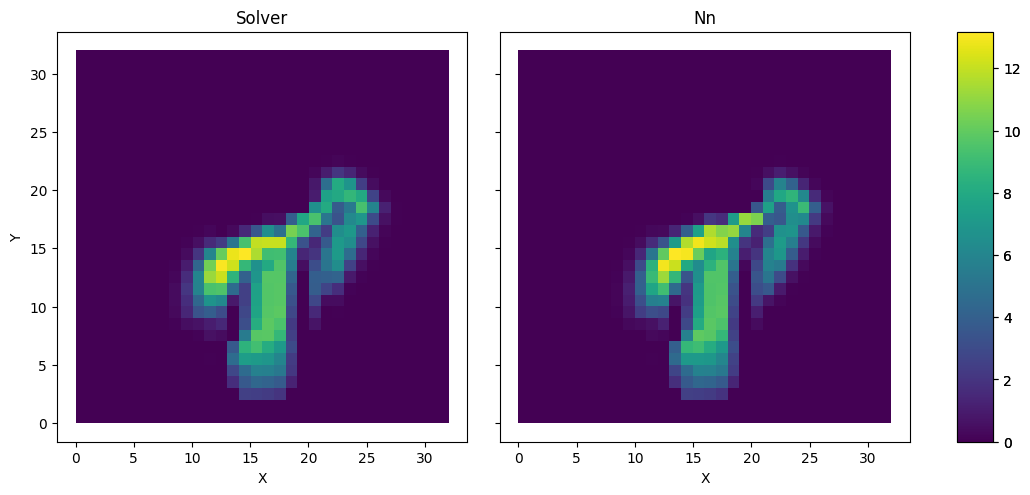

In [15]:
STEPS = 50
smk_solv = smoke
smk_nn = smoke
vel_smk_solv = vel_smk
vel_smk_nn = vel_smk
traj_smk_solv = [smk_solv]
traj_smk_nn = [smk_nn]

# flexible backends require a small workaround for PyTorch's no_grad context here; by default (eg for TF) use a null-context
from contextlib import nullcontext 
context = nullcontext() 
if any([b.name == 'torch' for b in BACKENDS]):
    context = torch.no_grad()

with context:
    for i in tqdm(range(STEPS)):
        smk_solv = advect.mac_cormack(smk_solv, vel_smk_solv, dt=dt) + INFLOW
        smk_nn = advect.mac_cormack(smk_nn, vel_smk_nn, dt=dt) + INFLOW
        
        buoyancy_force_solv = smk_solv * (0, 1.0) @ vel_smk_solv
        buoyancy_force_nn = smk_nn * (0, 1.0) @ vel_smk_nn
        
        vel_smk_solv, _ = step_obs(vel_smk_solv, dt, buoyancy_force_solv, [RECTANGLE])
        vel_smk_nn, _ = step_nn(vel_smk_nn, dt, buoyancy_force_nn, [RECTANGLE])
        
        traj_smk_solv.append(smk_solv)
        traj_smk_nn.append(smk_nn)

traj_smk_solv = field.stack(traj_smk_solv, batch('time'))
traj_smk_nn = field.stack(traj_smk_nn, batch('time'))

plot = vis.plot({"Solver": traj_smk_solv.time[STEPS-1], "NN": traj_smk_nn.time[STEPS-1]}) # show last frame

The plot above shows the last frame of the simulations, and they're remarkably similar. This results shows that the NN has successfully learned to reduce the divergence of arbitrary flows, despite having only seen the synthetic noisy inputs at training time.

Moreover, it highlights the success of the differentiable discrete operator used for training. The training converges very quickly, and the trained network generalizes in a _zero-shot_ fashion to completely new inputs. The network hasn't even seen any obstacles at training time, and can still infer (mostly correct) pressure fields to handle them. This aspect is nonetheless an interesting point for improvements of this implementation. The NN could receive the obstacle geometry as an additional input, and could be trained to pay special attention to the boundary region via increased loss values.

Lastly, if you're interested in watching the full evolution of the simulated trajectories, you can comment out and run the following cell. It generates a movie that can be watched in the browser via PhiFlow's `plot(...,animate=X)` function.

In [ ]:
#vis.plot({"solver": traj_smk_solv, "nn": traj_smk_nn}, animate='time') # uncomment to view animation

# Next Steps

- Improve the architecture of the neural network to boost its performance; obvious aspects to improve on are depth and features per layer, but other architectures are likewise worth a try.
- Especially fully convolutional architectures like the `res_net` above are worth a try: evaluate how well a trained NN with these architectures can handle new and larger input grids.
- Add support for obstacles with an additional input and an updated training data set.

